In [1]:
import os
from dotenv import load_dotenv
import json
import random
import matplotlib.pyplot as plt
import numpy as np
import asyncio

from benchmarklib import BenchmarkDatabase
from clique import CliqueProblem, CliqueTrial
from benchmarklib.compilers import CompileType, XAGCompiler

from qiskit_ibm_runtime import QiskitRuntimeService

import logging
from typing import Iterable, List, Tuple, Dict, Any, Union, Optional
import qiskit
from qiskit.providers import Backend
from qiskit import QuantumCircuit, transpile
import qiskit.transpiler.passes as passes_module
from qiskit.transpiler.basepasses import TransformationPass, BasePass
from qiskit.transpiler import PassManager
from qiskit.circuit.library import efficient_su2
from qiskit_ibm_transpiler.ai.routing import AIRouting
from qiskit_ibm_runtime import QiskitRuntimeService
import random

from sqlalchemy import select, func
from sqlalchemy.orm import joinedload

from tweedledum.bool_function_compiler import circuit_input, QuantumCircuitFunction
from tweedledum import BitVec

from benchmarklib import CompileType, BenchmarkDatabase
from benchmarklib import BatchQueue
from benchmarklib.compilers import SynthesisCompiler
from benchmarklib.pipeline.synthesis import QuantumMPC
from benchmarklib.utils.circuit import compute_circuit_metrics
from benchmarklib.algorithms.prediction import compute_analytic_success_rate_estimate1

from benchmarklib.runners.resource_management import run_with_resource_limits
from compiler_configs import compiler_qmpc_ai_test, compiler_qmpc_standard

In [2]:

 
backend = QiskitRuntimeService().backend("ibm_rensselaer")


In [3]:
benchmark_db = BenchmarkDatabase("clique.db", CliqueProblem, CliqueTrial)

In [7]:
# get the trials from AI transpiler and regular transpiler where they intersect on problem
# and create a dictionary mapping problem id to both trials
completed_problems = {}
with benchmark_db.session() as session:
    ai_trials = session.execute(
        select(CliqueTrial)
        .where(CliqueTrial.compiler_name == compiler_qmpc_ai_test.name, CliqueTrial._circuit_qpy != None)
        .options(joinedload(CliqueTrial.problem))
    ).scalars().all()
    problems = set(t.problem for t in ai_trials)
    standard_trials = session.execute(
        select(CliqueTrial)
        .where(CliqueTrial.compiler_name == compiler_qmpc_standard.name, CliqueTrial._circuit_qpy != None)
        .where(CliqueTrial.problem_id.in_([p.id for p in problems]))
    ).scalars().all()
    problems = set(t.problem for t in standard_trials)
    ai_trials = [t for t in ai_trials if t.problem in problems]

    for p in problems:
        completed_problems[p.id] = {
            "ai": None,
            "standard": None
        }

    for t in ai_trials:
        completed_problems[t.problem_id]["ai"] = t

    for t in standard_trials:
        completed_problems[t.problem_id]["standard"] = t

In [8]:
len(completed_problems)

14

In [9]:
trials = benchmark_db.query(
    select(CliqueTrial)
    .where(CliqueTrial._circuit_pretranspile_qpy != None, CliqueTrial._circuit_qpy != None)
    .order_by(func.random())
    .limit(20)
    .options(joinedload(CliqueTrial.problem))
    )
print(len(trials))

20


In [9]:
import datetime
metrics = []
now = datetime.datetime.now()
for problem_id, trial_pair in completed_problems.items():
    trial_standard = trial_pair["standard"]
    trial_ai = trial_pair["ai"]
    pretranspile_metrics = compute_circuit_metrics(trial_standard.circuit_pretranspile)
    posttranspile_metrics = compute_circuit_metrics(trial_standard.circuit)
    ai_transpile_metrics = compute_circuit_metrics(trial_ai.circuit)
    
    metrics.append({
        "pretranspile": pretranspile_metrics,
        "reg_transpile": posttranspile_metrics,
        "reg_success_rate": trial_standard.calculate_success_rate(),
        "reg_success_rate_pred": compute_analytic_success_rate_estimate1(backend, trial_standard.circuit),
        "ai_transpile": ai_transpile_metrics,
        "ai_success_rate": trial_ai.calculate_success_rate(),
        "ai_success_rate_pred": compute_analytic_success_rate_estimate1(backend, trial_ai.circuit, now),
    })

/home/eriku/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/eriku/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: counts is empty -- cannot compute success rate

In [11]:
import datetime
metrics = []
now = datetime.datetime.now()
for trial in trials:
    pretranspile_metrics = compute_circuit_metrics(trial.circuit_pretranspile)
    posttranspile_metrics = compute_circuit_metrics(trial.circuit)
    try:
        transpile_result = run_with_resource_limits(
            compiler_qmpc_ai_test.transpile,
            args=(trial.circuit_pretranspile,),
            memory_limit_mb=2024,
            timeout_seconds=600
        )
        ai_transpiled_circuit = transpile_result.result if transpile_result.success else None
        if ai_transpiled_circuit is None:
            raise Exception(transpile_result.error_message)
        ai_transpile_metrics = compute_circuit_metrics(ai_transpiled_circuit)
    except Exception as e:
        print(e)
        ai_transpiled_circuit = trial.circuit
        ai_transpile_metrics = posttranspile_metrics
    metrics.append({
        "pretranspile": pretranspile_metrics,
        "reg_transpile": posttranspile_metrics,
        "reg_success_rate": trial.calculate_success_rate(),
        "reg_success_rate_pred": compute_analytic_success_rate_estimate1(backend, trial.circuit),
        "ai_transpile": ai_transpile_metrics,
        "ai_success_rate_pred": compute_analytic_success_rate_estimate1(backend, ai_transpiled_circuit, now),
    })

INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
/home/eriku/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, 

Exceeded memory limit: 2313.50 MB > 2024 MB


INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.a

Exceeded memory limit: 2312.99 MB > 2024 MB


INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.a

Exceeded memory limit: 2424.85 MB > 2024 MB


INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.a

Exceeded memory limit: 2271.27 MB > 2024 MB


INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.a

Exceeded memory limit: 2275.98 MB > 2024 MB


INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.a

In [18]:
_metrics = metrics

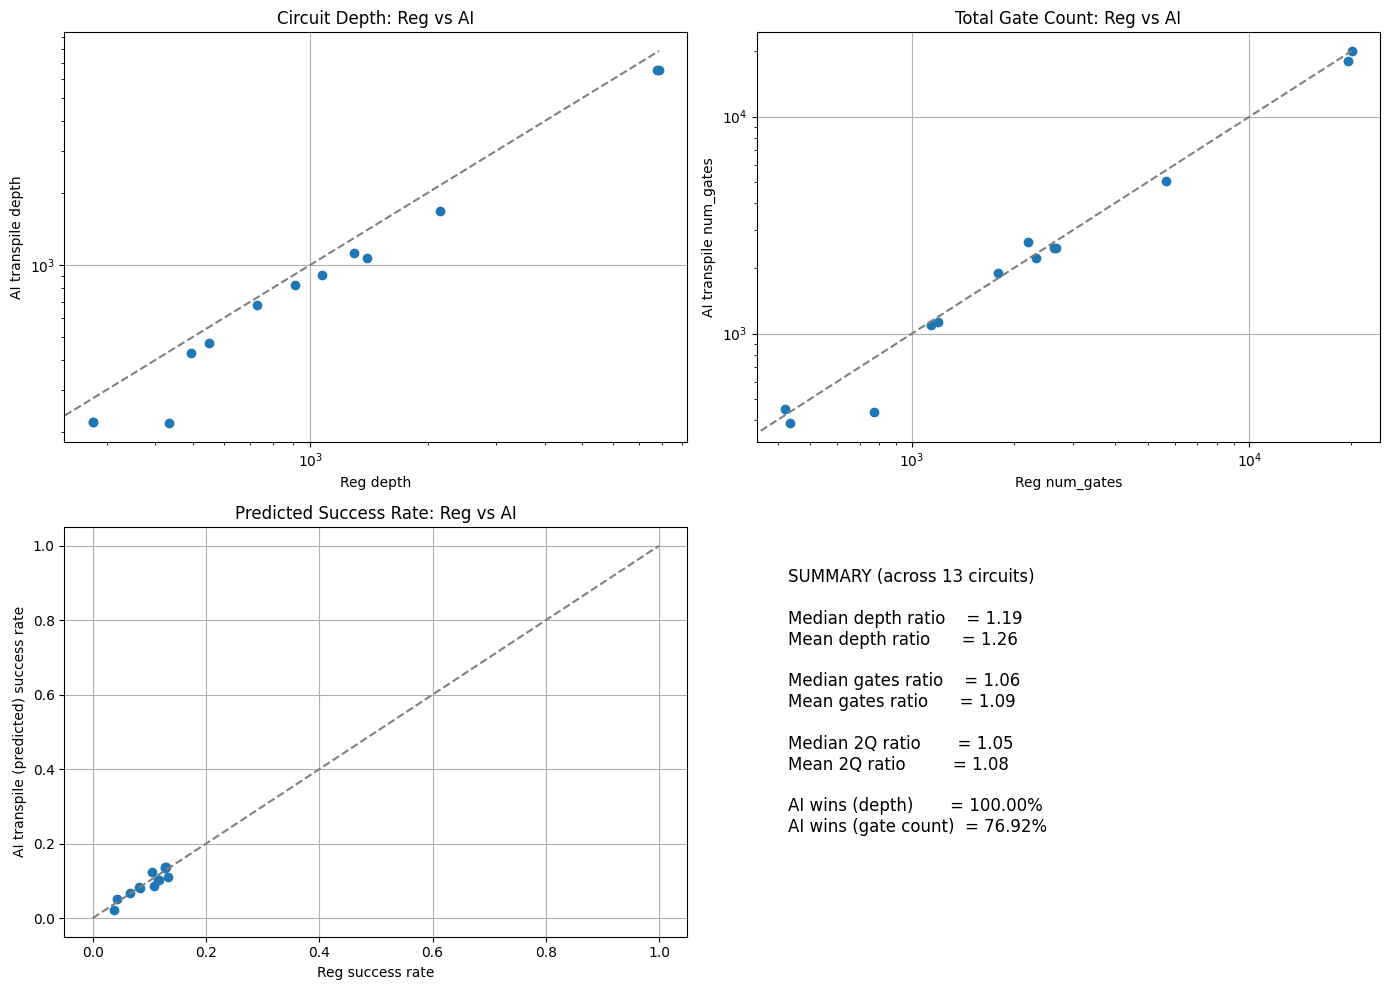

In [16]:
import matplotlib.pyplot as plt
import numpy as np

########################################################################
# EXPECTED INPUT: a list of dictionaries called "results"
#
# Example:
# results = [
#     {
#         "pretranspile": {...},
#         "posttranspile": {...},
#         "ai_transpile": {...}
#     },
#     ...
# ]
########################################################################

# ---- Helper function: count 2-qubit gates -----------------------------

def count_two_qubit_gates(op_counts):
    two_q_gate_names = ["cx", "ecr", "ccx", "ccrx", "ccrx_o1", "ccrx_o2"]
    return sum(op_counts.get(g, 0) for g in two_q_gate_names)


# ---- Gather metrics across circuits ----------------------------------

depth_reg = []
depth_ai = []
gates_reg = []
gates_ai = []
ratio_depth = []
ratio_gates = []
ratio_2q = []
success_reg = []
success_ai = []
success_pred_reg = []
success_pred_ai = []

for i, entry in enumerate(metrics):
    post = entry["reg_transpile"]
    ai = entry["ai_transpile"]

    d_post = post["circuit_depth"]
    d_ai = ai["circuit_depth"]
    g_post = post["circuit_num_gates"]
    g_ai = ai["circuit_num_gates"]

    depth_reg.append(d_post)
    depth_ai.append(d_ai)
    gates_reg.append(g_post)
    gates_ai.append(g_ai)
    success_reg.append(entry["reg_success_rate"])
    success_ai.append(entry["ai_success_rate"])
    success_pred_ai.append(entry["ai_success_rate_pred"])
    success_pred_reg.append(entry["reg_success_rate_pred"])

    ratio_depth.append(d_post / d_ai if d_ai != 0 else np.nan)
    ratio_gates.append(g_post / g_ai if g_ai != 0 else np.nan)

    post_2q = count_two_qubit_gates(post["circuit_op_counts"])
    ai_2q = count_two_qubit_gates(ai["circuit_op_counts"])
    ratio_2q.append(post_2q / ai_2q if ai_2q != 0 else np.nan)

    if d_ai * 2 < d_post:
        print(f"Circuit {i} depth improvement: Reg={d_post}, AI={d_ai}. Problem size: {trials[i].problem.nodes} Problem: {trials[i].problem.graph} Num solutions: {trials[i].problem.clique_counts[trials[i].problem.target_clique_size]}")


# Convert to numpy arrays
depth_reg = np.array(depth_reg)
depth_ai = np.array(depth_ai)
gates_reg = np.array(gates_reg)
gates_ai = np.array(gates_ai)
ratio_depth = np.array(ratio_depth)
ratio_gates = np.array(ratio_gates)
ratio_2q = np.array(ratio_2q)
success_reg = np.array(success_reg)
success_ai = np.array(success_ai)
success_pred_reg = np.array(success_pred_reg)
success_pred_ai = np.array(success_pred_ai)


# ---- Build the 4-panel Combined View ----------------------------------

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
(ax1, ax2), (ax3, ax4) = axes


# =====================
# 1. Scatter: Depth
# =====================
ax1.scatter(depth_reg, depth_ai)
max_depth = max(depth_reg.max(), depth_ai.max())
ax1.plot([0, max_depth], [0, max_depth], linestyle="--", color="gray")
ax1.set_title("Circuit Depth: Reg vs AI")
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel("Reg depth")
ax1.set_ylabel("AI transpile depth")
ax1.grid(True)


# =====================
# 2. Scatter: Total Gates
# =====================
ax2.scatter(gates_reg, gates_ai)
max_gates = max(gates_reg.max(), gates_ai.max())
ax2.plot([0, max_gates], [0, max_gates], linestyle="--", color="gray")
ax2.set_title("Total Gate Count: Reg vs AI")
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_xlabel("Reg num_gates")
ax2.set_ylabel("AI transpile num_gates")
ax2.grid(True)


# =====================
# 3. Scatter: Success Rate Prediction
# =====================
ax3.scatter(success_reg, success_ai)
ax3.plot([0, 1], [0, 1], linestyle="--", color="gray")
ax3.set_title("Predicted Success Rate: Reg vs AI")
ax3.set_xlabel("Reg success rate")
ax3.set_ylabel("AI transpile (predicted) success rate")
ax3.grid(True)


# =====================
# 4. Summary Table
# =====================
ax4.axis("off")

summary_text = f"""
SUMMARY (across {len(metrics)} circuits)

Median depth ratio    = {np.nanmedian(ratio_depth):.2f}
Mean depth ratio      = {np.nanmean(ratio_depth):.2f}

Median gates ratio    = {np.nanmedian(ratio_gates):.2f}
Mean gates ratio      = {np.nanmean(ratio_gates):.2f}

Median 2Q ratio       = {np.nanmedian(ratio_2q):.2f}
Mean 2Q ratio         = {np.nanmean(ratio_2q):.2f}

AI wins (depth)       = {(depth_ai < depth_reg).sum() / len(depth_reg):.2%}
AI wins (gate count)  = {(gates_ai < gates_reg).sum() / len(gates_reg):.2%}
"""

ax4.text(0.05, 0.95, summary_text, fontsize=12, va="top")

plt.tight_layout()
plt.show()